# Cooperative Cut

In this example we'll segment an image by Cooperative Cut and review the method along the way.

Cooperative Cut is an inference method for a class of higher-order energy functions that encourages homogeneous label transitions. For image segmentation, that means it encourages objects to have homogeneous boundaries.

Why would we care about this? A common approach to segmenting images is to formulate the problem as inference in a Markov Random Field (MRF) or Conditional Random Field (CRF) with "attractive potentials". This is mathematically equivalent to saying that the image is a grid graph, where each pixel is a node, and we cut out the object from the grid. The penalty we pay is the length of the cut, i.e., the length of the object boundary. Obviously, this encourages segmentations with short boundaries. But not all natural objects have short boundaries:

![A comparison of Graph Cut and Cooperative Cut.](files/figures/gcut_vs_coopcut.png)

How could we then identify a correct boundary? In many cases, the true boundary might have complex shape, but it is fairly uniform (congruous): the inside (object) colors as well as the background pattern do not change all that much. Therefore, cooperative cut models penalize boundary length only if the boundary is diverse, i.e., non-uniform.

How is this achieved? We group the edges in the grid graph into classes of similar edges (similarity is determined from the color, intensity or other features of the adjacent nodes). We then have a submodular function over the edges that gives a discount if we use lots of edges from the same class - the cost increase diminishes as we cut more and more edges from the same class. But for each new class of edges that occurs in the cut, we must pay. Therefore, the cost of the blue cut below increases linearly with its length, and the cost of the green cut gets discounts.

![Illustration of edge costs.](files/figures/costs.png)

Formally, the standard graph cut function counts the sum of edge weights

![Graph cut cost function](files/figures/gcutcost.png).

The submodular cut function looks at each edge class $E_k$ separately (one term in the sum for each class). Within each class, it counts the edge weights like the standard function, and then squashes them with a concave function $g_k$: 

![Cooperative cut cost function](files/figures/coopcost.png).

As a result, this function favors the continuation of similar boundaries over short-cuts, and helps to better segment fine structures.
The inference can be done by an iterative graph cut method, as described in the paper.

This also works for grayscale images, if we group edges by the ratios of the intensities of adjacent pixels:  
![A comparison of several segmentation methods.](files/figures/segmentations.jpg) 


Let's begin by looking at our input image and marks. These marks seed the foreground (red) and background (blue) models for segmentation as could be done interactively.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


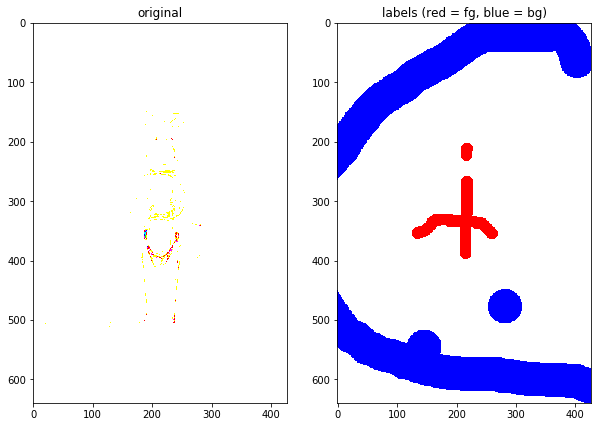

In [8]:
import numpy as np
import skimage.io
from sklearn import mixture
from pycoop.potentials import potentials
from pycoop import pycoop
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot, title, imshow
# load image and foreground / background label marks
im = skimage.io.imread('data/bee.jpg').astype(np.float64)
mark_im = skimage.io.imread('data/marks.png')[:,:,:-1]

# show image and labels
plt.rcParams['figure.figsize'] = (10, 10)
subplot(1,2,1)
title('original')
imshow(im*255)
subplot(1,2,2)
title('labels (red = fg, blue = bg)')
imshow(mark_im)

Note the fine structure of the bee's antennae, arms, and legs. Since the energy of many MRF models linearly increases in the length of the boundary these long, thin structures are often lost. This "shortcut" bias motivates the cooperative potentials of Cooperative Cut that give a discount in the energy to congruous boundaries in spite of their length.

As a warmup, let's take a look at a Gaussian mixture model (GMM) of the input image for a sense of its color distribution. The appearance models for our segmentation will be GMMs on the foreground and background. The next figure shows the assignment of the pixels to the mixtures of a 5 component GMM.

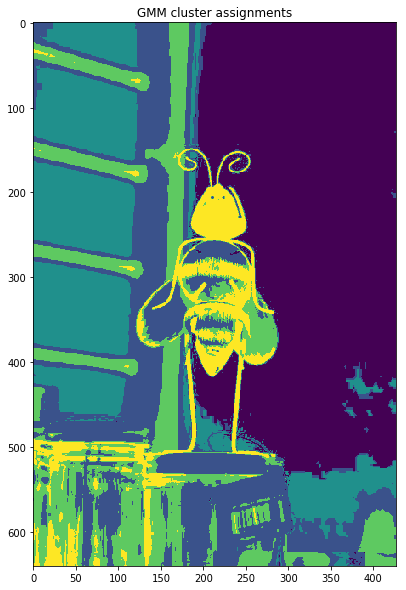

In [9]:
# GMM example: learn 5 component model on pixels, show cluster assignments
gmm = mixture.GaussianMixture(n_components=5, covariance_type='diag')
pix = im.reshape((-1, 3))
gmm.fit(pix)
gmm_im = gmm.predict(pix).reshape(im.shape[:-1])
title('GMM cluster assignments')
imshow(gmm_im)

To model the appearance of the foreground and background we will learn GMMs from the marked pixels in the input. The features are simply the RGB color of each pixel. Both mixture models have 5 components. The likelihood of the color under the foreground and background models gives the strength of the unary potentials at each pixel.

In [10]:
# GMM log-probabilities for unaries
fg_pix, bg_pix = potentials.extract_pix_from_marks(im, mark_im)
fg_gmm = potentials.learn_gmm(fg_pix)
bg_gmm = potentials.learn_gmm(bg_pix)
fg_un, bg_un = potentials.make_gmm_unaries(im.reshape((-1, 3)), fg_gmm, bg_gmm)

# show mask where the foreground models wins over the background, and the log ratio for the foreground model
subplot(1,2,1)
title('fg > bg mask')
imshow((fg_un > bg_un).reshape(im.shape[:-1]))
subplot(1,2,2)
title('fg logprob ratio')
imshow((fg_un - bg_un).reshape(im.shape[:-1]))

ValueError: too many values to unpack (expected 2)

The appearance alone cannot segment the bee. Boundary regularization is needed to remove background and reduce noise.

MRF models segment by defining and minimizing a joint energy over the appearance and boundaries of the segmentation. Graph Cut is an efficient method for optimizing these energies when the boundary term is simply a sum of edge weights. Cooperative Cut optimizes a higher-order energy defined over the whole boundary that favors congruous edges, like the black antennae of the bee for instance. The cooperative energy is approximately minimized by a series of graph cuts.

In [5]:
# create input graph for segmentation
ig = pycoop.InputGraph(im)

What makes a "congruous" boundary? We define congruence as a function of classes of similar edges. Edges are represented simply as the signed difference of the RGB colors at the ends of the directed edge. These edge features are clustered by k-means to yield edge classes. With these classes and a concave discount function e.g. the square root, the cooperative boundary energy is made submodular *within* classes but modular across classes. (This step may take a moment since the clustering is not optimized.)

(array([483376.,  21081.,  19461.,  80088.,      0.,   6460., 490900.,
          6269.,  72895., 999312.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

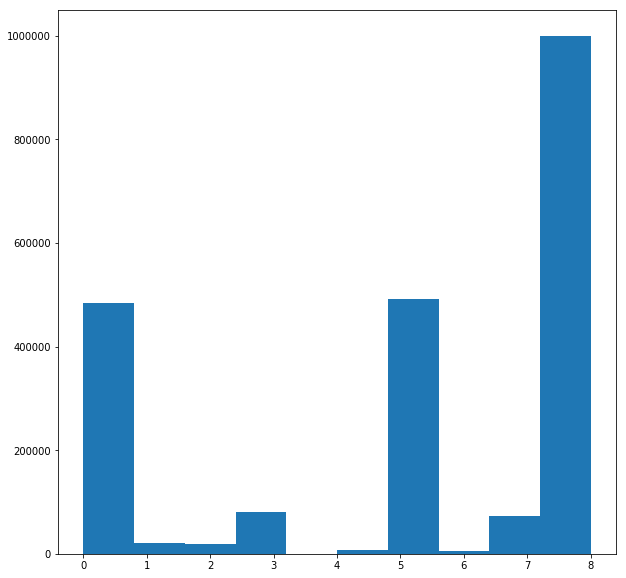

In [6]:
# cluster edge gradients to define classes
edge_cluster_classes, edge_centroids = potentials.cluster_edges(ig.edges, k=8)
plt.hist(edge_cluster_classes)

As expected, the variety in the image gives rise to edge classes that are not uniformally distributed. This is why the thresholds for boundary discounting are proportional to the total weight of a class and not absolute.

The last class is much larger than the rest. It is a special class for nearly identical edges in constant image regions; these are excluded from the submodular discount since they do not form boundaries.

Let's compare Cooperative Cut and Graph Cut segmentations. Cooperative Cut's boundary energy is a sum of thresholded submodular functions while Graph Cut's boundary is a sum and so fully modular. The boundary energy can be made fully submodular by relaxing the thresholds completely so that every edge is discounted in a "Submodular Cut."

In [11]:
# segment by coopcut, graphcut (full modular cut), and full submodular cut
ig.setClasses(edge_cluster_classes, 8)
ig.setUnaries(fg_un, bg_un)

label_im, cc_cost, cc_cut = pycoop.segment(ig, lambda_=2.5, theta=0.01, max_iter=12)
result_cc = np.ones_like(im)
result_cc[label_im] = im[label_im]*255
subplot(1,3,1)
title('coop cut')
imshow(result_cc)

label_im, cost, cut = pycoop.segment(ig, lambda_=2.5, theta=1, max_iter=12)
result_gc = np.ones_like(im)
result_gc[label_im] = im[label_im]*255
subplot(1,3,2)
title('graph cut')
imshow(result_gc)

label_im, cost, cut = pycoop.segment(ig, lambda_=2.5, theta=-1, max_iter=12)
result_submod = np.ones_like(im)
result_submod[label_im] = im[label_im]*255
subplot(1,3,3)
title('submod cut')
imshow(result_submod)

NameError: name 'fg_un' is not defined

Cooperative Cut regularizes away the background regions while retaining the fine structures. Graph Cut is susceptible to the shortcut bias in this instance. Submodular Cut shows the importance of thresholding the discount functions: without thresholds, the boundary is over-discounted so that nearly any arrangement yields a low energy.

- `lambda_` controls the regularization strength as the coefficient on the boundary term in the energy.
- `theta` is the difference threshold for "identical" edges s.t. these edges are never discounted. For no discounting i.e. Graph Cut, set this to `1`. For discounting of all edges, set this to `-1`.
- `max_iter` limits the number of iterations of the approximate inference routine. In practice it converges in $\sim$ 3-6 iterations.

Experiment with the parameters and try this example on your own image and marks!